In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import gcmpyo3

from core.amp.likelihood import logit_likelihood
from core.amp.prior.gaussian_prior import GaussianPrior
from core.amp.prior.nonseparable_gaussian_prior import NonSepGaussianPrior
from core.amp import gamp
from core.utility import KERNEL_COEFICIENTS, get_additional_noise_from_kappas, LOGISTIC_APPROX_COEF, sigmoid, build_gcm_from_activation

import simulations

%load_ext autoreload
%autoreload 2

In [2]:
d         = 200
n_over_d  = 2.0
seeds     = 1

noise_std = 0.5
noise_var = noise_std**2

activation= 'erf'
_, kappa1, kappastar = KERNEL_COEFICIENTS[activation]

In [5]:
inv_alpha_range = np.array([0.1, 0.14949494949494951, 0.198989898989899, 0.24848484848484848, 0.297979797979798, 0.3474747474747475, 0.396969696969697, 0.44646464646464656, 0.495959595959596, 0.5454545454545455, 0.5949494949494949, 0.6444444444444445, 0.693939393939394, 0.7434343434343434, 0.7929292929292932, 0.8424242424242424, 0.891919191919192, 0.9414141414141416, 0.990909090909091, 1.0404040404040404, 1.0898989898989901, 1.1393939393939396, 1.188888888888889, 1.2383838383838386, 1.287878787878788, 1.3373737373737375, 1.386868686868687, 1.4363636363636367, 1.4858585858585862, 1.5353535353535357, 1.5848484848484852, 1.6343434343434347, 1.6838383838383841, 1.7333333333333334, 1.782828282828283, 1.8323232323232326, 1.881818181818182, 1.9313131313131315, 1.9808080808080812, 2.0303030303030307, 2.0797979797979806, 2.1292929292929297, 2.178787878787879, 2.2282828282828286, 2.277777777777778, 2.327272727272728, 2.376767676767677, 2.4262626262626266, 2.4757575757575765, 2.525252525252526, 2.5747474747474755, 2.624242424242425, 2.6737373737373744, 2.7232323232323234, 2.772727272727274, 2.8222222222222233, 2.8717171717171723, 2.921212121212122, 2.9707070707070717, 3.020202020202021, 3.06969696969697, 3.11919191919192, 3.168686868686869, 3.2181818181818187, 3.267676767676768, 3.3171717171717177, 3.366666666666668, 3.416161616161617, 3.465656565656567, 3.5151515151515156, 3.564646464646465, 3.6141414141414154, 3.663636363636365, 3.713131313131313, 3.7626262626262625, 3.812121212121213, 3.8616161616161624, 3.911111111111112, 3.9606060606060622, 4.010101010101011, 4.05959595959596, 4.10909090909091, 4.158585858585859, 4.208080808080809, 4.257575757575759, 4.307070707070707, 4.356565656565657, 4.406060606060607, 4.455555555555557, 4.505050505050505, 4.5545454545454565, 4.604040404040404, 4.653535353535354, 4.703030303030304, 4.752525252525253, 4.802020202020202, 4.851515151515152, 4.901010101010103, 4.950505050505051, 5.0])
erm_lambda_evidence = np.array([3.8568089029482686, 2.667828904522541, 2.07706863752476, 1.7262922044251576, 1.495279123545244, 1.3323192684263088, 1.211519422555393, 1.1185076236872933, 1.044717250980127, 0.9847542603648818, 0.9350825358201031, 0.8932876472155645, 0.8576641882632622, 0.8269745599756574, 0.8002872528197515, 0.7768912208512203, 0.7562322236892252, 0.7378715226787035, 0.7214573123962261, 0.706705103641931, 0.6933811971507109, 0.6812951763291182, 0.670286025868688, 0.6602162403520255, 0.6509773983072578, 0.6424717369320883, 0.6346173033405674, 0.6273444656017297, 0.6205885668009933, 0.6143031499826903, 0.6084376816200319, 0.6029543061574341, 0.5978132267140882, 0.5929919680328847, 0.5884547628702067, 0.5841799774240998, 0.5801456823108957, 0.5763323994681031, 0.5727226430287463, 0.5693022041780592, 0.5660543746457566, 0.5629696002759473, 0.5600325339702801, 0.5572354035718748, 0.5545678619173607, 0.552021218801001, 0.5495875387479179, 0.5472595615661077, 0.545029175397457, 0.542892235083224, 0.5408429147316836, 0.5388765256029519, 0.5369866170734141, 0.5351695360234127, 0.5334211904448841, 0.5317377820920937, 0.5301157882775033, 0.5285519331820129, 0.527043169546516, 0.525586658263847, 0.5241797492438647, 0.5228199691641372, 0.5215050040788347, 0.5202326893619724, 0.5190009962680325, 0.517808022231916, 0.5166519800385475, 0.5155311896306823, 0.5144440775354179, 0.513389566618906, 0.512365419932918, 0.5113707390475936, 0.5104042769881976, 0.5094648560751918, 0.5085513624293213, 0.5076627428724038, 0.506797999895757, 0.5059561885642937, 0.5051364125656695, 0.5043378221857155, 0.5035596099794368, 0.5028010091867252, 0.5020612909073204, 0.5013397618147023, 0.5006357618048897, 0.4999486622441103, 0.4992775515798068, 0.4986223258674938, 0.4979824412897131, 0.4973572223927929, 0.4967461723464988, 0.4961488165136953, 0.4955647018440029, 0.4949938776327991, 0.4944349637870532, 0.4938880439901846, 0.4933527377573866, 0.4928286791813545, 0.4923155184932398, 0.4918129212972972])

index = [ i for i in range(0, len(inv_alpha_range), 5) if 4.5 >= inv_alpha_range[i] >= 0.5 ]
inv_alpha_range = inv_alpha_range[index]
erm_lambda_evidence = erm_lambda_evidence[index]
n_alpha = len(inv_alpha_range)

In [4]:
max_p        = int(n_over_d * d * inv_alpha_range[-1])
F_global     = np.random.normal(0.0, 1.0, size=(max_p, d)) / np.sqrt(d)

In [6]:
v_array, q_array, m_array = np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha))
for s in range(seeds):
    try:
        m_list, q_list, v_list = simulations.eb_trial(d, n_over_d, inv_alpha_range, erm_lambda_evidence, kappa1, kappastar, noise_std, F_global)
        q_array[s] = q_list
        m_array[s] = m_list
        v_array[s] = v_list
    except Exception as e:
        print(e)
        q_array[s] = q_array[s-1]
        m_array[s] = m_array[s-1]
        v_array[s] = v_array[s-1]

9it [02:25, 27.17s/it]

In [74]:
m_list = np.mean(m_array, axis = 0)
q_list = np.mean(q_array, axis = 0)
v_list = np.mean(v_array, axis = 0)

In [75]:
qs_for_eb_evidence = []
ms_for_eb_evidence = []
vs_for_eb_evidence = []

for inv_alpha, lambda_ in tqdm(zip(inv_alpha_range, erm_lambda_evidence)):
    alpha = 1. / inv_alpha
    gamma = n_over_d / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.pseudo_bayes_state_evolution_gcm(alpha, 1.0, noise_var, gamma, kappa1, kappastar, lambda_, 1.0, "logit", 1e-6, True, True, False)
    qs_for_eb_evidence.append(q)
    ms_for_eb_evidence.append(m)
    vs_for_eb_evidence.append(v)

16it [00:02,  7.15it/s]


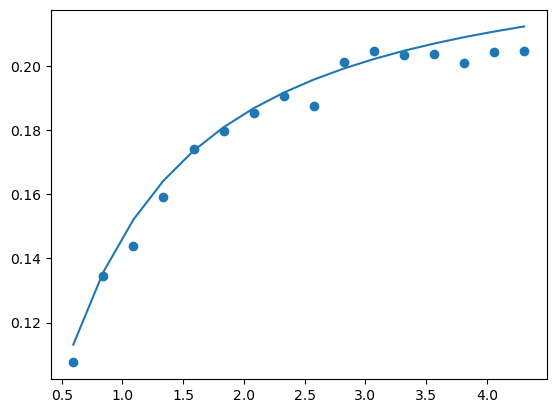

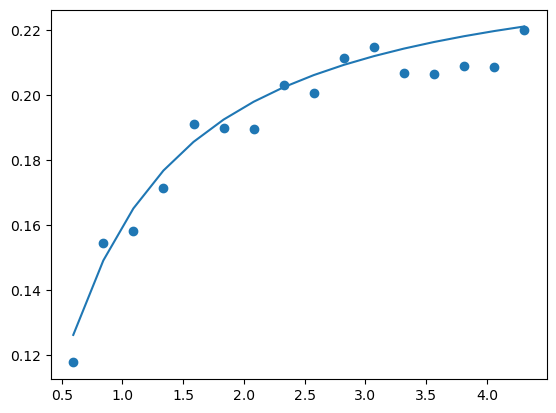

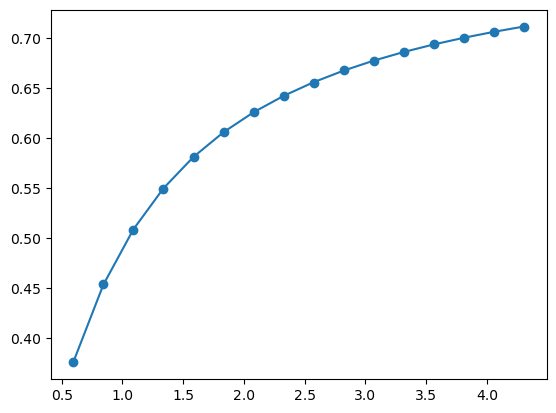

In [76]:
plt.scatter(inv_alpha_range, q_list)
plt.plot(inv_alpha_range, qs_for_eb_evidence)
plt.show()

plt.scatter(inv_alpha_range, m_list)
plt.plot(inv_alpha_range, ms_for_eb_evidence)
plt.show()

plt.scatter(inv_alpha_range, v_list)
plt.plot(inv_alpha_range, vs_for_eb_evidence)
plt.show()

In [77]:
print('Experimental values of m : ')
print(list(m_list))
print('Experimental values of q : ')
print(list(q_list))
print('Experimental values of v : ')
print(list(v_list))

[0.5949494949494949, 0.8424242424242424, 1.0898989898989901, 1.3373737373737375, 1.5848484848484852, 1.8323232323232326, 2.0797979797979806, 2.327272727272728, 2.5747474747474755, 2.8222222222222233, 3.06969696969697, 3.3171717171717177, 3.564646464646465, 3.812121212121213, 4.05959595959596, 4.307070707070707]
[0.11763268728923057, 0.15444476053880438, 0.15798261185832643, 0.17122110418450937, 0.19114142869114942, 0.18978971567772168, 0.18950468933948406, 0.20305074293038192, 0.20057807425124058, 0.21138659011443703, 0.2146407382496675, 0.20661837526027743, 0.20651063376635678, 0.20875738004470334, 0.20850225845214582, 0.2198516952463027]
[0.1075934776297081, 0.1344425525770833, 0.14395744705494745, 0.15904559154994113, 0.1740496931056065, 0.17955816700054023, 0.1851850989622415, 0.1904491320591174, 0.18745211169895332, 0.2013420231358713, 0.20457578688124195, 0.20328846748098006, 0.2037005785473597, 0.20092610223797863, 0.2043449564209865, 0.2045482693459162]
[0.3759868903715158, 0.4